# 1 Introduction
<br>
This notebook extracts the values of points in novelty areas from the ECP classified image|.

# 2 Functions

In [1]:
# library used
from osgeo import gdal
from osgeo.gdalconst import *
import os
def image_to_arrays(image):
    '''
    This function read the output image from atmopheric correction and deglint, which
    have the following structure bands:
    0: B2
    1: B3
    2: B4
    3: B5
    4: B6
    Then, it returns the arrays of all bands.
    -----------------------
    image(str): image path
    -----------------------
    return: the five bands necessary for the OWT classification.

    '''
    
    # abre a imagem
    image =  gdal.Open(image, GA_ReadOnly)
    # abre as bandas
    bandas = image.ReadAsArray()

    # seleciona cada banda
    b2 = bandas[0]
    b3 = bandas[1]
    b4 = bandas[2]
    b5 = bandas[3]
    b6 = bandas[4]


    return b2, b3, b4, b5, b6

def array_to_image(img, i, path, geotransform, projection):
    '''
    This function convert a array to tiff
    -----------------------------
    img (np.array): an image array.
    i (str): image name.
    path: path for saving the tiff image.
    geotransform: Geotransform for saving the image (e.g.: image.GetGeoTransform()).
    projection: Projection for saving the image (e.g.: image.GetProjection())
    '''   
    # save results
    # set image dimensions
    image_size = img.shape
    nx = image_size[0]
    ny = image_size[1]

    # create the classified raster file
    dst_ds = gdal.GetDriverByName('GTiff').Create(path+i, ny, nx, 1, gdal.GDT_Int16)

    dst_ds.SetGeoTransform(geotransform)    # specify coords
    dst_ds.SetProjection(projection) # export coords to file       
    dst_ds.GetRasterBand(1).WriteArray(img)   # write r-band to the raster
    dst_ds.GetRasterBand(1).SetNoDataValue(0) 
    dst_ds.FlushCache()                     # write to disk


# 3 Split the multi-band raster into 5 rasters
<br>
This process is needed for using the package 'rasterstats'

In [2]:
# read bands
path = '00_Database/03_Images/02_ECP/'
img = 'T22JGS_20190724T132241B2B3B4B5b6.tif'
b2, b3, b4, b5, b6 = image_to_arrays(path+img)

# read geotransform and projection

img_ref = gdal.Open(path+img, GA_ReadOnly)
geotransform = img_ref.GetGeoTransform()
proj = img_ref.GetProjection()

# save bands
array_to_image(b2,
               'ecp_b2.tif',
               path,
               geotransform,
               proj)

array_to_image(b3,
               'ecp_b3.tif',
               path,
               geotransform,
               proj)

array_to_image(b4,
               'ecp_b4.tif',
               path,
               geotransform,
               proj)

array_to_image(b5,
               'ecp_b5.tif',
               path,
               geotransform,
               proj)

array_to_image(b6,
               'ecp_b6.tif',
               path,
               geotransform,
               proj)

# 4 Extract values

In [3]:
# library used
from rasterstats import point_query

# extract novelty values
novelty_pixel_values = {}
for x in ['ecp_b2.tif', 'ecp_b3.tif', 'ecp_b4.tif', 'ecp_b5.tif', 'ecp_b6.tif']:
    
    ext_points = '00_Database/04_Masks/01_ECP/ecp_novelty_samples.shp'
    img = '00_Database/03_Images/02_ECP/'+x
    values = point_query(ext_points, img)
    band_name = x.split('_')[1].split('.')[0]
    novelty_pixel_values[band_name] = values
    

# 5 Data processing and access to OWT1 reference samples

In [4]:
# library used
import pandas as pd
import numpy as np

# create dataframes
novelty_pixel_values = pd.DataFrame(novelty_pixel_values)
novelty_pixel_values.columns = [492, 560, 665, 704, 741]

# owt 1 in situ samples used for trainning the classification algorithm
insitu_db = pd.read_csv('00_Database/01_Tables/insitu_db.csv', index_col=0)
owt1_insitu_reference_samples = insitu_db[['OWTs', 'B2', 'B3', 'B4', 'B5','B6']]
owt1_insitu_reference_samples = owt1_insitu_reference_samples[owt1_insitu_reference_samples['OWTs'] == 'OWT 1']
owt1_insitu_reference_samples = owt1_insitu_reference_samples.drop('OWTs', axis=1)
owt1_insitu_reference_samples.columns = [492, 560, 665, 704, 741]

#normalize to Rrs (norm)
novelty_pixel_values = novelty_pixel_values.divide(novelty_pixel_values.sum(axis=1), axis=0)
owt1_insitu_reference_samples = owt1_insitu_reference_samples.divide(owt1_insitu_reference_samples.sum(axis=1), axis=0)

# data manipulation for ploting using seaborn
owt1_insitu_reference_samples['Source'] = 'OWT 1 field reference'
novelty_pixel_values['Source'] = 'Extraction points'
dataset = owt1_insitu_reference_samples.append(novelty_pixel_values)
newdataset492 = dataset.loc[:,[492, 'Source']]
newdataset492['Wavelength'] = 492

newdataset560 = dataset.loc[:,[560, 'Source']]
newdataset560['Wavelength'] = 560

newdataset665 = dataset.loc[:,[665, 'Source']]
newdataset665['Wavelength'] = 665

newdataset704 = dataset.loc[:,[704, 'Source']]
newdataset704['Wavelength'] = 704

newdataset741 = dataset.loc[:,[741, 'Source']]
newdataset741['Wavelength'] = 741

dataset = np.concatenate((newdataset492.values, newdataset560.values, newdataset665.values, newdataset704.values, newdataset741.values))
dataset = pd.DataFrame(dataset, columns=['Rrs', 'Source', 'Wavelength'])
dataset['Rrs'] = pd.to_numeric(dataset['Rrs'])
dataset['Wavelength'] = pd.to_numeric(dataset['Wavelength'])


# 6 Graphics

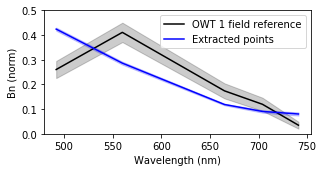

In [5]:
# library used
import matplotlib.pyplot as plt
import seaborn as sns

# plot
fig = plt.figure(figsize=(4.6,2.5))
ax = plt.subplot(1, 1, 1)

sns.lineplot(x='Wavelength',
             y='Rrs',
             hue='Source',
             data=dataset,
             palette=['black', 'blue'],
             ci='sd',
             ax=ax)

plt.ylim(0,0.5)
plt.ylabel('Bn (norm)', fontsize=10)
plt.xlabel('Wavelength (nm)')
ax.legend()
ax.legend(labels=['OWT 1 field reference','Extracted points'])
plt.tight_layout()

In [6]:
fig.savefig('00_Database/00_Figures/ECP_extracted_values.png', dpi=300)